# BL40A2020 Wireless Communication Systems

## Week 6: Channel coding and basics of Shannon Information Theory

## Author: Pedro Nardelli


In [1]:
! pip install scikit-dsp-comm

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
! pip install komm

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import math
import komm
import sympy as sp
from sympy.stats import Normal, density, E, std, cdf
sp.init_printing() 
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.interpolate as interp
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
import ipywidgets
from scipy.stats import binom

# Binary symmetric channel

![](https://upload.wikimedia.org/wikipedia/commons/b/b5/Binary_symmetric_channel.svg)

Let's consider the following.

- Pr[transmit 0] = $q$
- Pr[transmit 1] = $1-q$
- Pr[receive 0 | transmit 0] = $1-p$
- Pr[receive 0 | transmit 1] = $p$
- Pr[receive 1 | transmit 1] = $1-p$
- Pr[receive 1 | transmit 0] = $p$

Probability theory states the following relations:

## Law of total probability
### Pr[receive 0] = Pr[receive 0 | transmit 0] x Pr[transmit 0] + Pr[receive 0 | transmit 1] x Pr[transmit 1] = $p + q - 2pq$
### Pr[receive 1] = Pr[receive 1 | transmit 0] x Pr[transmit 0] + Pr[receive 1 | transmit 1] x Pr[transmit 1] = $1 - (p + q - 2pq)$

## Bayes
### Pr[transmit X | receive Y] x Pr[receive Y] = Pr[receive Y | transmit X] x Pr[transmit X]


## Experiment 

In [4]:
input_seq_size = 1000# sequence
tp = np.arange(0, input_seq_size , 1)
p_aux = 0.5 ## Uniform distribution of input
input_seq = np.random.choice([0, 1], size=input_seq_size, p=[p_aux, 1-p_aux])
p =0.1
bsc = komm.BinarySymmetricChannel(p)
output_seq = bsc(input_seq)
p_r0 = (1-p)*p_aux + p*(1-p_aux)
p_t0_r0 = (1-p)*p_aux/p_r0
p_t1_r1 = (1-p)*(1-p_aux)/(1-p_r0)
num_zeros = (input_seq == 0).sum()
num_ones = (input_seq == 1).sum()
num_zeros_bsc = (output_seq== 0).sum()
num_ones_bsc = (output_seq == 1).sum()
print("Simulation vs. analytical results")
print("#################")
print("Input")
print("Probability input 0", num_zeros/input_seq_size, "Analytical:", p_aux)
print("Probability input 1:", num_ones/input_seq_size, "Analytical:", 1 - p_aux)
print("#################")
print("Output")
print("Probability output 0:", num_zeros_bsc/input_seq_size, "Analytical:", p_r0)
print("Probability output 1:",num_ones_bsc/input_seq_size, "Analytical:", 1 - p_r0)
print("#################")
print("Error probability due to channel")
count_0_1 = 0
count_1_0 = 0
for i in range(input_seq_size):
    if input_seq[i] != output_seq[i]:
        if input_seq[i] == 0:
            count_0_1 = count_0_1 +1
        if input_seq[i] == 1:
            count_1_0 = count_1_0 +1
print("Probability output 0 given input 1:",count_0_1/num_zeros, "Analytical:", p)
print("Probability output 1 given input 0:",count_1_0/num_ones, "Analytical:", p)

Simulation vs. analytical results
#################
Input
Probability input 0 0.509 Analytical: 0.5
Probability input 1: 0.491 Analytical: 0.5
#################
Output
Probability output 0: 0.506 Analytical: 0.5
Probability output 1: 0.494 Analytical: 0.5
#################
Error probability due to channel
Probability output 0 given input 1: 0.11591355599214145 Analytical: 0.1
Probability output 1 given input 0: 0.11405295315682282 Analytical: 0.1


## Repetition code

- To decrease the error probability to an arbitrary value
- For each input, repeat the bit $n$ times
- Code rate: $1/n$
- Decision: Majority rule; if equal number of symbols, random choice (50%-50%).

*Error probability is given by the Binomial distribution as*

- For $n$ odd:

$$1 - \mathrm{Prob}\left[k \leq n/2 \right] = 1 - \sum_{i=0}^{n/2}\binom{n}{k}p^k(1-p)^{n-k},$$

- For $n$ even:

$$1- (\mathrm{Prob}\left[k < n/2 \right] + 0.5 \cdot \mathrm{Prob}\left[k = n/2 \right]) = 1 - \sum_{i=0}^{n/2}\binom{n}{k}p^k(1-p)^{n-k} - 0.5 \cdot \binom{n}{n/2}p^{n/2}(1-p)^{n/2}.$$


#### First test using [komm](https://komm.readthedocs.io/en/latest/komm.RepetitionCode/)

In [5]:
code_length = 20
rep_code = komm.RepetitionCode(code_length)
coded_input = rep_code.encode(input_seq[0])
coded_bsc = bsc(coded_input)
decoded = rep_code.decode(coded_bsc)
print("Input:", input_seq[0])
print("Coded:", coded_input)
print("After BSC:", coded_bsc)
print("Decoded:", decoded)

Input: 0
Coded: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
After BSC: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Decoded: [0]


#### We can now remake your simulations based on this code as follows.

In [6]:
input_seq_size = 1000# sequence
tp = np.arange(0, input_seq_size , 1)
p_aux = 0.5 ## Uniform distribution of input
input_seq = np.random.choice([0, 1], size=input_seq_size, p=[p_aux, 1-p_aux])
p =0.1
bsc = komm.BinarySymmetricChannel(p)
output_seq = bsc(input_seq)
output_seq_coded = np.zeros(input_seq_size)
#####
#####
code_length = 20
rep_code = komm.RepetitionCode(code_length)
for i in range(input_seq_size):
    coded_input = rep_code.encode(input_seq[i])
    coded_bsc = bsc(coded_input)
    output_seq_coded[i] = rep_code.decode(coded_bsc)
#####
p_r0 = (1-p)*p_aux + p*(1-p_aux)
p_t0_r0 = (1-p)*p_aux/p_r0
p_t1_r1 = (1-p)*(1-p_aux)/(1-p_r0)
num_zeros = (input_seq == 0).sum()
num_ones = (input_seq == 1).sum()
num_zeros_bsc = (output_seq== 0).sum()
num_ones_bsc = (output_seq == 1).sum()
count_uncoded = 0
count_coded = 0
for i in range(input_seq_size):
    if input_seq[i] != output_seq[i]:
        count_uncoded = count_uncoded + 1
    if input_seq[i] != output_seq_coded[i]:
        count_coded = count_coded + 1
print("Probability of error uncoded:",count_uncoded/input_seq_size, "Analytical:", p)
print("Number of repetitions:", code_length)
if code_length % 2 == 0: ## % is the "mod" function - gives the "rest" in the division
    error_coded = 1 - (binom.cdf(code_length/2 - 1, code_length, p) + (binom.cdf(code_length/2, code_length, p) - binom.cdf(code_length/2-1, code_length, p))*0.5) #codelenght even number
else:
    error_coded = 1 - binom.cdf(code_length/2, code_length, p) 
print("Probability of error coded:",count_coded/input_seq_size, "Analytical:", error_coded)

Probability of error uncoded: 0.105 Analytical: 0.1
Number of repetitions: 20
Probability of error coded: 0.0 Analytical: 3.929882327113887e-06


## Channel capacity

- It is possible to transmit with arbitrary low error probabilities with coding rates $R$ smaller the the channel capacity $C$. 
- Achievable rates: $R<C$
- Shannon capacity: $C = \max\limits_{p_X(x)} I(X;Y)$
- $I(X;Y)$ is the mutual information of the random variables $X$ and $Y$

**Definitions**

Mutual information between  $X$ and $Y$ quantifies how much *uncertainty* about one random variable is decreased by knowing the other random variable: $$I(X;Y) = H(Y) - H(Y \; | \; X)  = H(X) - H(X \; | \; Y)$$:

$H(X)$ is the entropy and measures uncertainty (called *surprise* function) so that: $$H(X) = - \sum\limits_i p(x_i) \log p(x_i)$$

#### For the BSC:

$$I(X;Y) = H(Y) - H(Y \; | \; X)  = H(Y) - \sum\limits_{x=0}^1 p(X=x) H(Y \; | \; X=x)  = H(Y) + p \log_2(p) + (1-p) \log_2(1-p) \leq 1 +  p \log_2(p) + (1-p) \log_2(1-p) = 1 - H_\mathrm{b}(p)$$

where the inequality comes from the fact thar $H(Y) \leq 1$ and therefore maximized $I(X;Y)$; $H_\mathrm{b}(p) = p \log_2(p) + (1-p) \log_2(1-p)$ is the binary entropy function.

- **BSC channel capacity: $C_\mathrm{BSC} = 1 - H_\mathrm{b}(p)$** 
- Physical limit of the BSC channel: Nothing can be better than this!!!
- How to design a code to reach this is another completely different story....


### Perfomance analysis

In [7]:
p=0.3
code_length_plot = np.arange(1,31,1)
error_coded_plot = np.zeros(len(code_length_plot))
for i in code_length_plot:
    if i % 2 == 0: ## % is the "mod" function - gives the "rest" in the division
        error_coded_plot[i-1] = 1 - (binom.cdf(i/2 - 1, i, p) + (binom.cdf(i/2, i, p) - binom.cdf(i/2-1, i, p))*0.5)
    else:
        error_coded_plot[i-1]  = 1 - binom.cdf(i/2, i, p)

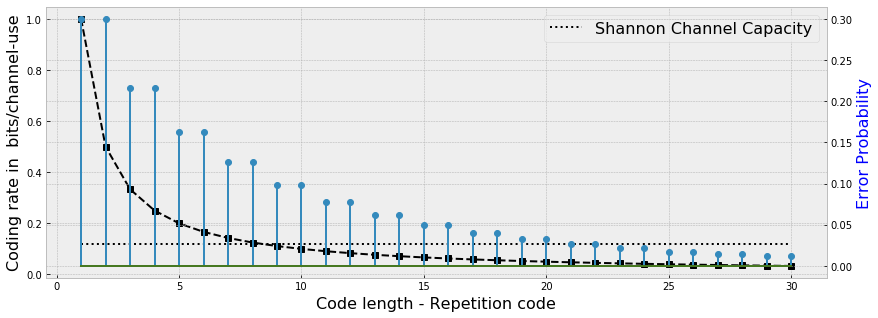

In [8]:
fig, ax1 = plt.subplots(figsize=(14,5))
ax2 = ax1.twinx()
ax1.plot(code_length_plot, 1/code_length_plot,"ks--")
ax1.plot([1,30],[komm.BinarySymmetricChannel(p).capacity(),komm.BinarySymmetricChannel(p).capacity()] ,"k:",label='Shannon Channel Capacity')
ax2.stem(code_length_plot, error_coded_plot)
ax1.set_xlabel('Code length - Repetition code',fontsize=16)
ax1.set_ylabel('Coding rate in  bits/channel-use', color='k',fontsize=16)
ax2.set_ylabel('Error Probability', color='b',fontsize=16)
ax1.legend(fontsize=16)
plt.show() 

#### Channel capacity

Text(0.02, 0.075, 'Achievable rates')

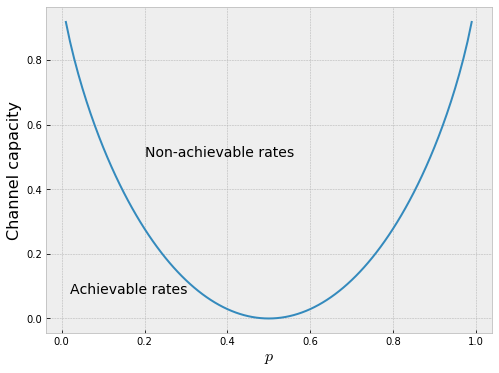

In [9]:
error_prob = np.arange(0,1,0.01);
capacity_bsc = np.zeros(len(error_prob));
for i in range(len(error_prob)):
    capacity_bsc[i] = komm.BinarySymmetricChannel(error_prob[i]).capacity()
plt.rcParams['figure.figsize'] = 8, 6
plt.plot(error_prob,capacity_bsc);
#plt.fill_between(error_prob, 0, capacity_bsc);
plt.xlabel('$p$',fontsize=16);
plt.ylabel('Channel capacity',fontsize=16);
plt.text(0.2,0.5,'Non-achievable rates',fontsize=14)
plt.text(0.02,0.075,'Achievable rates',fontsize=14)

## Shannon capacity for AWGN

- $C = \log_2(1+ \mathrm{SNR})$ in bits/s/Hz
- How is this related to $M$-ary modulation like $M$-QAM?

**Symbol error probability in $M$-QAM with $M = 2^k$**

$$P \leq 4 Q\left( \sqrt{\dfrac{3 k E_b}{(M-1) N_0}}\right)$$

In [10]:
def Q(x):
    return 1/2*scipy.special.erfc(x/np.sqrt(2))

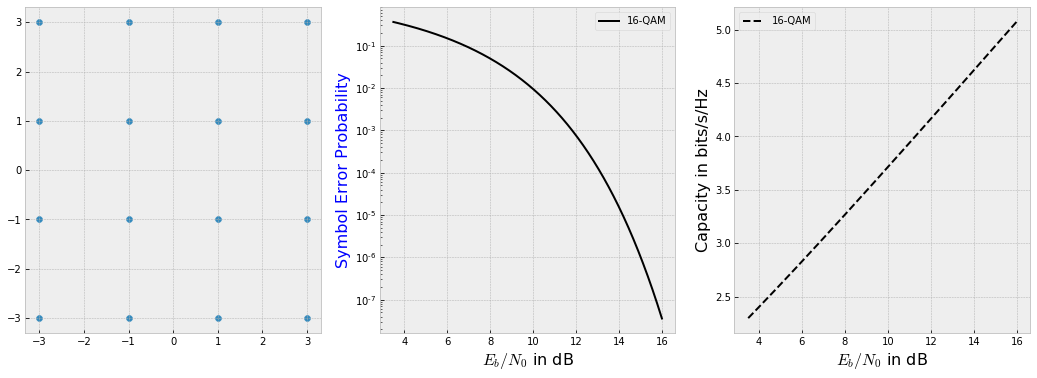

In [12]:
###################################
#16-QAM
base_amplitude = 1
awgn = komm.AWGNChannel()
noise_power_db_16qam = np.arange(-12, 0.5, 0.01)
noise_power_16qam = 10**(noise_power_db_16qam / 10)
order = 16
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_16qam  = modulation.energy_per_symbol
awgn.snr_16qam  = awgn.signal_power_16qam  / noise_power_16qam
EbperN0_16qam  = awgn.snr_16qam / modulation.bits_per_symbol
error_probability_16qam  = 4*Q(np.sqrt( 3* (np.log2(order)/(order-1)) * EbperN0_16qam)) 
#
###
plt.figure(1,figsize=(18,6))
plt.subplot(131)
plt.scatter(modulation.constellation.real,modulation.constellation.imag);

plt.subplot(132)
plt.semilogy(10 * np.log10(EbperN0_16qam), error_probability_16qam,'k',label='16-QAM');
plt.xlabel('$E_b/N_0$ in dB',fontsize=16)
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.legend()

plt.subplot(133)
plt.plot(10 * np.log10(EbperN0_16qam), np.log(1+awgn.snr_16qam),'--k',label='16-QAM');
plt.xlabel('$E_b/N_0$ in dB',fontsize=16);
plt.ylabel('Capacity in bits/s/Hz', color='k',fontsize=16);
plt.legend();


### Let's compare this with 4-QAM, 16-QAM and 64-QAM

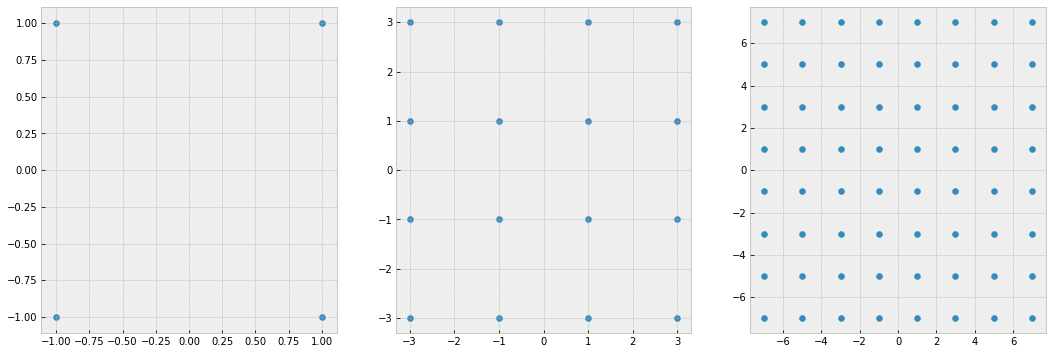

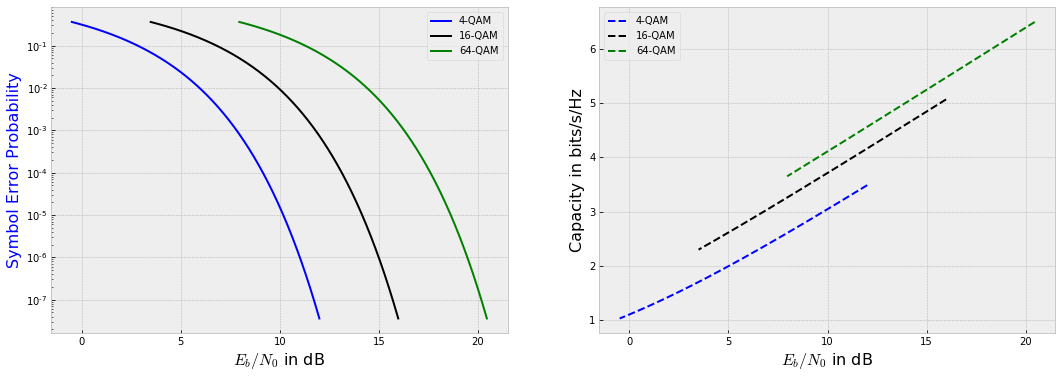

In [13]:
#4-QAM
base_amplitude = 1
noise_power_db_4qam = np.arange(-12, 0.5, 0.01)
noise_power_4qam = 10**(noise_power_db_4qam / 10)
awgn = komm.AWGNChannel()
order = 4
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_4qam  = modulation.energy_per_symbol
awgn.snr_4qam  = awgn.signal_power_4qam  / noise_power_4qam
EbperN0_4qam  = awgn.snr_4qam / modulation.bits_per_symbol
error_probability_4qam  = 4*Q(np.sqrt( 3* (np.log2(order)/(order-1)) * EbperN0_4qam))  ## eq. (5.2-80) from Proakis
#
plt.figure(1,figsize=(18,6))
plt.subplot(131)
plt.scatter(modulation.constellation.real,modulation.constellation.imag);
###################################
#16-QAM
base_amplitude = 1
noise_power_db_16qam = np.arange(-12, 0.5, 0.01)
noise_power_16qam = 10**(noise_power_db_16qam / 10)
order = 16
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_16qam  = modulation.energy_per_symbol
awgn.snr_16qam  = awgn.signal_power_16qam  / noise_power_16qam
EbperN0_16qam  = awgn.snr_16qam / modulation.bits_per_symbol
error_probability_16qam  = 4*Q(np.sqrt( 3* (np.log2(order)/(order-1)) * EbperN0_16qam)) 
#
plt.subplot(132)
plt.scatter(modulation.constellation.real,modulation.constellation.imag);
################################
#64-QAM
base_amplitude = 1
noise_power_db_64qam = np.arange(-12, 0.5, 0.01)
noise_power_64qam = 10**(noise_power_db_64qam / 10)
order = 64
modulation = komm.QAModulation(order, base_amplitude)
awgn.signal_power_64qam  = modulation.energy_per_symbol
awgn.snr_64qam  = awgn.signal_power_64qam  / noise_power_64qam
EbperN0_64qam  = awgn.snr_64qam / modulation.bits_per_symbol
error_probability_64qam  = 4*Q(np.sqrt( 3* (np.log2(order)/(order-1)) * EbperN0_64qam)) 
#
plt.subplot(133)
plt.scatter(modulation.constellation.real,modulation.constellation.imag);
#
plt.show()


###
plt.figure(1,figsize=(18,6))
plt.subplot(121)
plt.semilogy(10 * np.log10(EbperN0_4qam), error_probability_4qam,'b',label='4-QAM');
plt.semilogy(10 * np.log10(EbperN0_16qam), error_probability_16qam,'k',label='16-QAM');
plt.semilogy(10 * np.log10(EbperN0_64qam), error_probability_64qam,'g',label='64-QAM');
plt.xlabel('$E_b/N_0$ in dB',fontsize=16)
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.legend()

plt.subplot(122)
plt.plot(10 * np.log10(EbperN0_4qam), np.log(1+awgn.snr_4qam),'--b',label='4-QAM');
plt.plot(10 * np.log10(EbperN0_16qam), np.log(1+awgn.snr_16qam),'--k',label='16-QAM');
plt.plot(10 * np.log10(EbperN0_64qam), np.log(1+awgn.snr_64qam),'--g',label='64-QAM');
plt.xlabel('$E_b/N_0$ in dB',fontsize=16);
plt.ylabel('Capacity in bits/s/Hz', color='k',fontsize=16);
plt.legend();


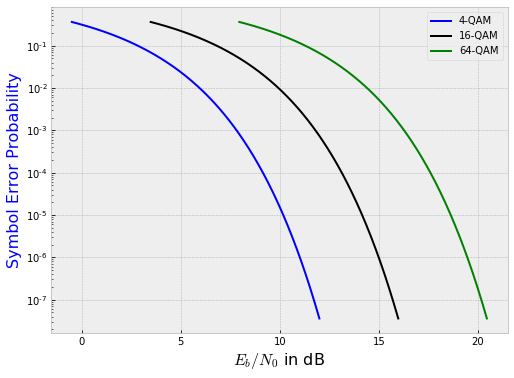

In [14]:
plt.figure(1,figsize=(18,6))
plt.subplot(121)
plt.semilogy(10 * np.log10(EbperN0_4qam), error_probability_4qam,'b',label='4-QAM');
plt.semilogy(10 * np.log10(EbperN0_16qam), error_probability_16qam,'k',label='16-QAM');
plt.semilogy(10 * np.log10(EbperN0_64qam), error_probability_64qam,'g',label='64-QAM');
plt.xlabel('$E_b/N_0$ in dB',fontsize=16)
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.legend();